**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Please note that this notebook is most likely going to cause a stuck process. So if you are going to run it, please make sure to restart your jupyter notebook as soon as you completed running it.

The bug happens inside the `fastText` library, which we have no control over. You can check the status of this issue: [here](https://github.com/fastai/fastai/issues/754) and [here](https://github.com/facebookresearch/fastText/issues/618#issuecomment-419554225).

For the future, note that there're 3 separate implementations of fasttext, perhaps one of them works:
https://github.com/facebookresearch/fastText/tree/master/python
https://pypi.org/project/fasttext/
https://radimrehurek.com/gensim/models/fasttext.html#module-gensim.models.fasttext

## Translation files

In [ ]:
from fastai.text import *

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html .  It was created by Chris Callison-Burch, who crawled millions of web pages and then used *a set of simple heuristics to transform French URLs onto English URLs (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other*.

In [ ]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [ ]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [ ]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

In [ ]:
qs[:5], len(qs)

([('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')],
 52331)

In [ ]:
en_qs,fr_qs = zip(*qs)

In [ ]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [ ]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [ ]:
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

In [ ]:
np.percentile([len(o) for o in en_tok], 90), np.percentile([len(o) for o in fr_tok], 90)

(23.0, 28.0)

In [ ]:
keep = np.array([len(o)<30 for o in en_tok])

In [ ]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [ ]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

In [ ]:
en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

In [ ]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [ ]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [ ]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [ ]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [ ]:
[fr_itos[o] for o in fr_ids[0]], len(en_itos), len(fr_itos)

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?', '_eos_'], 17573, 24793)

## Word vectors

fasttext word vectors available from https://fasttext.cc/docs/en/english-vectors.html

In [ ]:
# ! pip install git+https://github.com/facebookresearch/fastText.git

In [ ]:
import fastText as ft

To use the fastText library, you'll need to download [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).

In [ ]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

In [ ]:
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [ ]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [ ]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [ ]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [ ]:
ft_words = en_vecs.get_words(include_freq=True)
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

In [ ]:
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

In [ ]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()

(0.0075652334, 0.29283327)

## Model data

In [ ]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(29, 33)

In [ ]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [ ]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [ ]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

In [ ]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [ ]:
bs=125

In [ ]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [ ]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [ ]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(33, 29), (21, 7), (21, 8), (33, 13), (33, 21)]

## Initial model

In [ ]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

In [ ]:
nh,nl = 256,2

In [ ]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [ ]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


A Jupyter Widget

 17%|█▋        | 64/377 [00:09<00:47,  6.62it/s, loss=11.2]

Exception in thread Thread-242:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 70%|███████   | 265/377 [00:39<00:16,  6.64it/s, loss=30]  


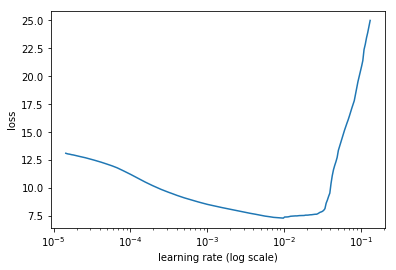

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

A Jupyter Widget

  6%|▌         | 22/377 [00:04<01:06,  5.34it/s, loss=10.8]   


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/jhoward/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jhoward/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jhoward/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      5.48978    5.462648  
    1      4.616437   4.770539                              
    2      4.345884   4.37726                               
    3      3.857125   4.136014                              
    4      3.612306   3.941867                              
    5      3.375064   3.839872                              
    6      3.383987   3.708972                              
    7      3.224772   3.664173                              
    8      3.238523   3.604765                              
    9      2.962041   3.587814                              
    10     2.96163    3.574888                              
    11     2.866477   3.581224                              



[3.5812237]

In [ ]:
learn.save('initial')

In [ ]:
learn.load('initial')

### Test

In [ ]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quels facteurs pourraient influer sur le choix de leur emplacement ? _eos_
what factors influencetheir location ? _eos_
what factors might might influence on the their ? ? _eos_

qu’ est -ce qui ne peut pas changer ? _eos_
what can not change ? _eos_
what not change change ? _eos_

que faites - vous ? _eos_
what do you do ? _eos_
what do you do ? _eos_

qui réglemente les pylônes d' antennes ? _eos_
who regulates antenna towers ? _eos_
who regulates the doors doors ? _eos_

où sont - ils situés ? _eos_
where are they located ? _eos_
where are the located ? _eos_

quelles sont leurs compétences ? _eos_
what are their qualifications ? _eos_
what are their skills ? _eos_

qui est victime de harcèlement sexuel ? _eos_
who experiences sexual harassment ? _eos_
who is victim sexual sexual ? ? _eos_

quelles sont les personnes qui visitent les communautés autochtones ? _eos_
who visits indigenous communities ? _eos_
who are people people aboriginal aboriginal ? _eos_

pourquoi ces trois point

## Bidir

In [ ]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10))

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      4.896942   4.761351  
    1      4.323335   4.260878                              
    2      3.962747   4.06161                               
    3      3.596254   3.940087                              
    4      3.432788   3.944787                              
    5      3.310895   3.686629                              
    6      3.454976   3.638168                              
    7      3.093827   3.588456                              
    8      3.257495   3.610536                              
    9      3.033345   3.540344                              
    10     2.967694   3.516766                              
    11     2.718945   3.513977                              



[3.5139771]

In [ ]:
learn.save('bidir')

## Teacher forcing

In [ ]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

In [ ]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      4.460622   12.661013 
    1      3.468132   7.138729                              
    2      3.235244   6.202878                              
    3      3.101616   5.454283                              
    4      3.135989   4.823736                              
    5      2.980696   4.933402                              
    6      2.91562    4.287475                              
    7      3.032661   3.975346                              
    8      3.103834   3.790773                              
    9      3.121457   3.578682                              
    10     2.917534   3.532427                              
    11     3.326946   3.490643                              



[3.490643]

In [ ]:
learn.save('forcing')

## Attentional model

In [ ]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [ ]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [ ]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
lr=2e-3

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      3.882168   11.125291 
    1      3.599992   6.667136                              
    2      3.236066   5.552943                              
    3      3.050283   4.919096                              
    4      2.99024    4.500383                              
    5      3.07999    4.000295                              
    6      2.891087   4.024115                              
    7      2.854725   3.673913                              
    8      2.979285   3.590668                              
    9      3.109851   3.459867                              
    10     2.92878    3.517598                              
    11     2.778292   3.390253                              
    12     2.795427   3.388423                              
    13     2.809757   3.353334                              
    14     2.6723     3.368584                              



[3.3685837]

In [ ]:
learn.save('attn')

In [ ]:
learn.load('attn')

### Test

In [ ]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [ ]:
for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quels facteurs pourraient influer sur le choix de leur emplacement ? _eos_
what factors influencetheir location ? _eos_
what factors might influence the their their their ? _eos_

qu’ est -ce qui ne peut pas changer ? _eos_
what can not change ? _eos_
what can not change change ? _eos_

que faites - vous ? _eos_
what do you do ? _eos_
what do you do ? _eos_

qui réglemente les pylônes d' antennes ? _eos_
who regulates antenna towers ? _eos_
who regulates the lights ? ? _eos_

où sont - ils situés ? _eos_
where are they located ? _eos_
where are they located ? _eos_

quelles sont leurs compétences ? _eos_
what are their qualifications ? _eos_
what are their skills ? _eos_

qui est victime de harcèlement sexuel ? _eos_
who experiences sexual harassment ? _eos_
who is victim sexual sexual ? _eos_

quelles sont les personnes qui visitent les communautés autochtones ? _eos_
who visits indigenous communities ? _eos_
who is people people aboriginal people ? _eos_

pourquoi ces trois points en

In [ ]:
attn = to_np(attns[...,180])

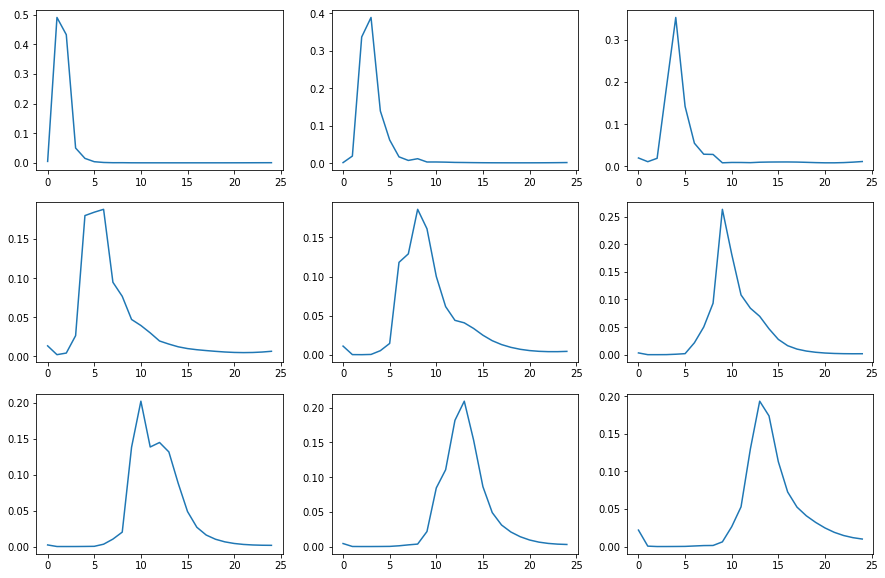

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

## All

In [ ]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [ ]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [ ]:
learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      3.817306   7.527982  
    1      3.239813   5.82099                               
    2      3.06717    5.437195                              
    3      3.077923   4.718295                              
    4      2.952973   4.337892                              
    5      3.018182   3.994012                              
    6      2.761607   3.777056                              
    7      2.913683   3.595531                              
    8      2.91521    3.46984                               
    9      2.921533   3.370839                              
    10     2.913826   3.336167                              
    11     2.746896   3.37274                               
    12     2.695839   3.332427                              
    13     2.531583   3.341861                              
    14     2.524642   3.324184                              



[3.3241842]

### Test

In [ ]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quels facteurs pourraient influer sur le choix de leur emplacement ? _eos_
what factors influencetheir location ? _eos_
what factors might affect the choice of their ? ? _eos_

qu’ est -ce qui ne peut pas changer ? _eos_
what can not change ? _eos_
what can not change change _eos_

que faites - vous ? _eos_
what do you do ? _eos_
what do you do ? _eos_

qui réglemente les pylônes d' antennes ? _eos_
who regulates antenna towers ? _eos_
who regulates the antenna ? ? _eos_

où sont - ils situés ? _eos_
where are they located ? _eos_
where are they located ? _eos_

quelles sont leurs compétences ? _eos_
what are their qualifications ? _eos_
what are their skills ? _eos_

qui est victime de harcèlement sexuel ? _eos_
who experiences sexual harassment ? _eos_
who is victim harassment harassment ? _eos_

quelles sont les personnes qui visitent les communautés autochtones ? _eos_
who visits indigenous communities ? _eos_
who are the people people ? ?

pourquoi ces trois points en particulier 